In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")

In [3]:
epoch_key = ("bon", 3, 2)
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

In [4]:
from replay_trajectory_classification import ClusterlessClassifier

model_name = f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl'
classifier = ClusterlessClassifier.load_model(model_name)

classifier

ClusterlessClassifier(discrete_transition_diag=0.98, movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=3.0, replay_speed=1)

In [5]:
results = xr.open_dataset(
    f'{animal}_{day:02}_{epoch:02}.nc',
    group=f'/{data_type}/{dim}/classifier/ripples/')
results

<xarray.Dataset>
Dimensions:            (position: 101, ripple_number: 251, state: 3, time: 127)
Coordinates:
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.252000
  * position           (position) float64 1.481 4.442 7.404 ... 315.1 318.0
  * ripple_number      (ripple_number) int64 1 2 3 4 5 6 ... 247 248 249 250 251
Data variables:
    acausal_posterior  (ripple_number, time, state, position) float64 ...

In [6]:
import itertools
from logging import getLogger

import numpy as np
import pandas as pd
from scipy.signal import filtfilt

from loren_frank_data_processing import (get_all_multiunit_indicators,
                                         get_all_spike_indicators,
                                         get_interpolated_position_dataframe,
                                         get_LFPs, get_position_dataframe,
                                         get_trial_time, make_epochs_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe)
from ripple_detection import (Kay_ripple_detector,
                              get_multiunit_population_firing_rate)
from ripple_detection.core import _get_ripplefilter_kernel

from os.path import abspath, dirname, join, pardir

import numpy as np

from loren_frank_data_processing import Animal
from replay_trajectory_classification.misc import NumbaKDE

# LFP sampling frequency
SAMPLING_FREQUENCY = 500

# Data directories and definitions
RAW_DATA_DIR = join(pardir, "Raw-Data")

ANIMALS = {
    'bon': Animal(directory=join(RAW_DATA_DIR, 'Bond'), short_name='bon'),
}

_MARKS = ['channel_1_max', 'channel_2_max', 'channel_3_max', 'channel_4_max']
_BRAIN_AREAS = ['CA1', 'CA2', 'CA3']

def filter_ripple_band(data, sampling_frequency=1500):
    '''Returns a bandpass filtered signal between 150-250 Hz

    Parameters
    ----------
    data : array_like, shape (n_time,)

    Returns
    -------
    filtered_data : array_like, shape (n_time,)

    '''
    filter_numerator, filter_denominator = _get_ripplefilter_kernel()
    is_nan = np.isnan(data)
    filtered_data = np.full_like(data, np.nan)
    filtered_data[~is_nan] = filtfilt(
        filter_numerator, filter_denominator, data[~is_nan], axis=0)
    return filtered_data


def get_ripple_times(epoch_key, sampling_frequency=1500,
                     brain_areas=['CA1', 'CA2', 'CA3']):
    position_info = (
        get_interpolated_position_dataframe(epoch_key, ANIMALS)
        .dropna(subset=['linear_position', 'speed']))
    speed = position_info['speed']
    time = position_info.index
    tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
        epoch_key, drop_level=False)
    if ~np.all(np.isnan(tetrode_info.validripple.astype(float))):
        tetrode_keys = tetrode_info.loc[
            (tetrode_info.validripple == 1)].index
    else:
        is_brain_areas = (
            tetrode_info.area.astype(str).str.upper().isin(brain_areas))
        tetrode_keys = tetrode_info.loc[is_brain_areas].index

    lfps = get_LFPs(tetrode_keys, ANIMALS).reindex(time)
    ripple_filtered_lfps = pd.DataFrame(
        np.stack([filter_ripple_band(
            lfps.values[:, ind], sampling_frequency=1500)
            for ind in np.arange(lfps.shape[1])], axis=1),
        index=lfps.index)

    ripple_times = Kay_ripple_detector(
        time, lfps.values, speed.values, sampling_frequency,
        zscore_threshold=2.0, close_ripple_threshold=np.timedelta64(0, 'ms'),
        minimum_duration=np.timedelta64(15, 'ms'))

    return ripple_times, ripple_filtered_lfps, lfps


def load_data(epoch_key, brain_areas=None):

    if brain_areas is None:
        brain_areas = _BRAIN_AREAS

    time = get_trial_time(epoch_key, ANIMALS)
    time = (pd.Series(np.ones_like(time, dtype=np.float), index=time)
            .resample('2ms').mean()
            .index)

    def _time_function(*args, **kwargs):
        return time

    position_info = (
        get_interpolated_position_dataframe(
            epoch_key, ANIMALS, _time_function)
        .dropna(subset=['linear_position', 'speed']))

    ripple_times, _, _ = get_ripple_times(
        epoch_key)

    return {
        'position_info': position_info,
        'ripple_times': ripple_times,
        'sampling_frequency': SAMPLING_FREQUENCY,
    }


In [7]:
data = load_data(epoch_key)

22-Dec-20 14:54:28 Failed to load file: ../Raw-Data/Bond/bonDIO03.mat
22-Dec-20 14:54:28 No DIO file found, using distance from well to segment trials
22-Dec-20 14:54:29 Failed to load file: ../Raw-Data/Bond/bonDIO03.mat
22-Dec-20 14:54:29 No DIO file found, inferring correct inbound/outbound from task rules
22-Dec-20 15:11:57 Failed to load file: ../Raw-Data/Bond/bonDIO03.mat
22-Dec-20 15:11:57 No DIO file found, using distance from well to segment trials
22-Dec-20 15:11:58 Failed to load file: ../Raw-Data/Bond/bonDIO03.mat
22-Dec-20 15:11:58 No DIO file found, inferring correct inbound/outbound from task rules


In [8]:
from loren_frank_data_processing import reshape_to_segments

ripple_position_info = reshape_to_segments(data["position_info"], data['ripple_times'])

In [9]:
from loren_frank_data_processing.position import make_track_graph

track_graph, _ = make_track_graph(epoch_key, ANIMALS)

In [16]:
from trajectory_analysis_tools import (get_ahead_behind_distance,
                                       get_trajectory_data)

def plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info):
    posterior = (
        results
        .acausal_posterior
        .sel(ripple_number=ripple_number)
        .dropna('time', how='all')
        .sum("state", skipna=False)
        .assign_coords(
            time=lambda ds: 1000 * ds.time /
            np.timedelta64(1, 's')))

    (actual_projected_position, actual_edges, actual_orientation,
            mental_position_2d, mental_position_edges) = get_trajectory_data(
        posterior, track_graph, classifier, ripple_position_info.loc[ripple_number])

    ahead_behind_distance = get_ahead_behind_distance(
            track_graph, actual_projected_position, actual_edges, actual_orientation,
            mental_position_2d, mental_position_edges)
    fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True)

    cmap = plt.cm.bone_r
    cmap.set_bad("grey", alpha=0.5)
    posterior.plot(
            x="time", y="position", robust=True, ax=axes[0],
            cmap=cmap, vmin=0.0, rasterized=True,
        )
    axes[0].plot(posterior.time, ripple_position_info.loc[ripple_number].linear_position,
                 color="magenta", linestyle='--', linewidth=2, zorder=101, clip_on=False)
    sns.despine(ax=axes[0], offset=5, trim=False)
    axes[0].set_xlabel("")

    map_position_ind = (
        posterior.where(classifier.is_track_interior_).argmax(
            "position", skipna=True).values
    )
    map_position_1d = classifier.place_bin_centers_[
        map_position_ind]
    axes[0].plot(posterior.time, map_position_1d, linewidth=2, color="green", zorder=100)
    axes[0].set_ylabel("Position [cm]")

    axes[1].plot(posterior.time, ahead_behind_distance,
                 color="green", linewidth=2)
    axes[1].axhline(0, color='magenta', linestyle='--', linewidth=2)
    max_dist = np.max(np.abs(ahead_behind_distance)) + 5
    axes[1].set_ylim((-max_dist, max_dist))
    axes[1].text(0, max_dist-1, "Ahead", color="grey")
    axes[1].text(0, -max_dist+1, "Behind", color="grey")
    axes[1].set_ylabel("Distance\nfrom animal [cm]")
    sns.despine(ax=axes[1], offset=5, trim=False)
    axes[1].set_xlabel("Time [ms]")

    plt.figure()
    plt.plot(data["position_info"].x_position, data["position_info"].y_position, color="lightgrey")

    for (x, y), head_dir in zip(actual_projected_position, actual_orientation):
        plt.arrow(
            x,
            y,
            1e-5 * np.cos(head_dir),
            1e-5 * np.sin(head_dir),
            zorder=1000,
            head_width=1.5,
            linewidth=3,
            color="magenta",
        )

    plt.plot(mental_position_2d[:, 0], mental_position_2d[:, 1], linewidth=2, color="green")
    plt.scatter(mental_position_2d[:, 0], mental_position_2d[:, 1], zorder=100, color="green")
    plt.title(f"ripple_number = {ripple_number}")
    sns.despine()

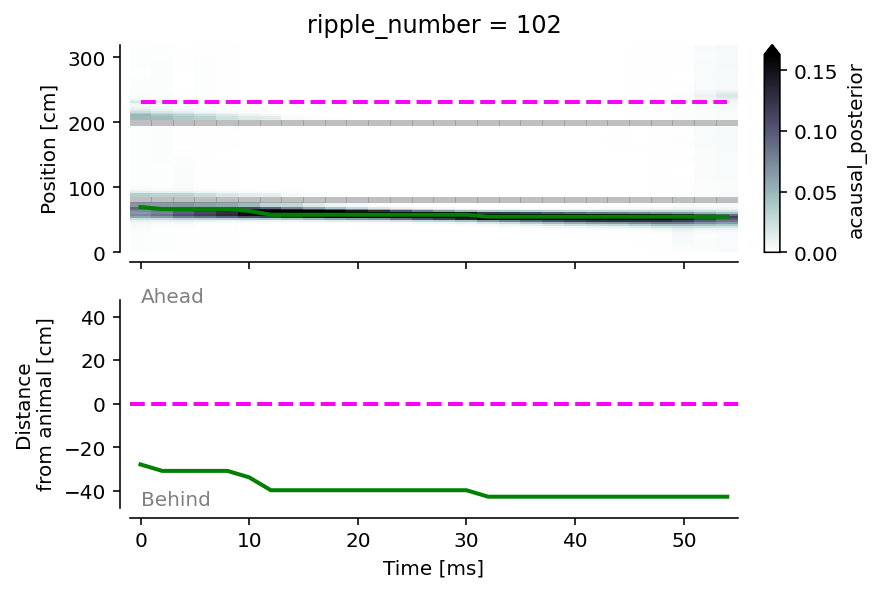

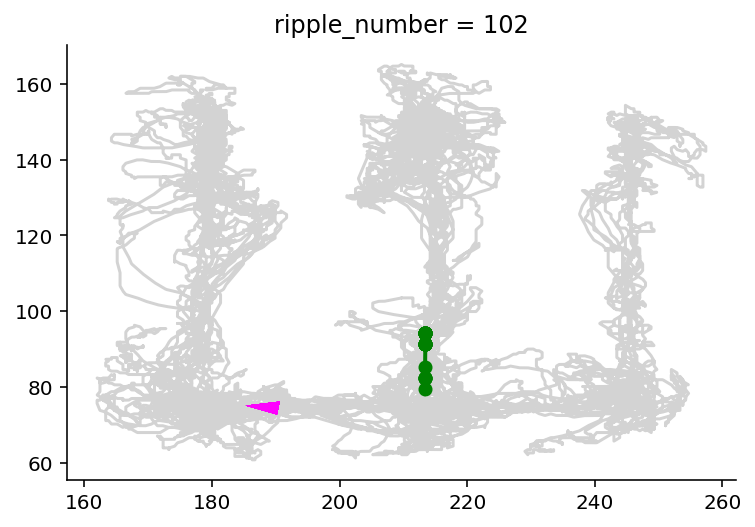

In [17]:
ripple_number = 102

plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

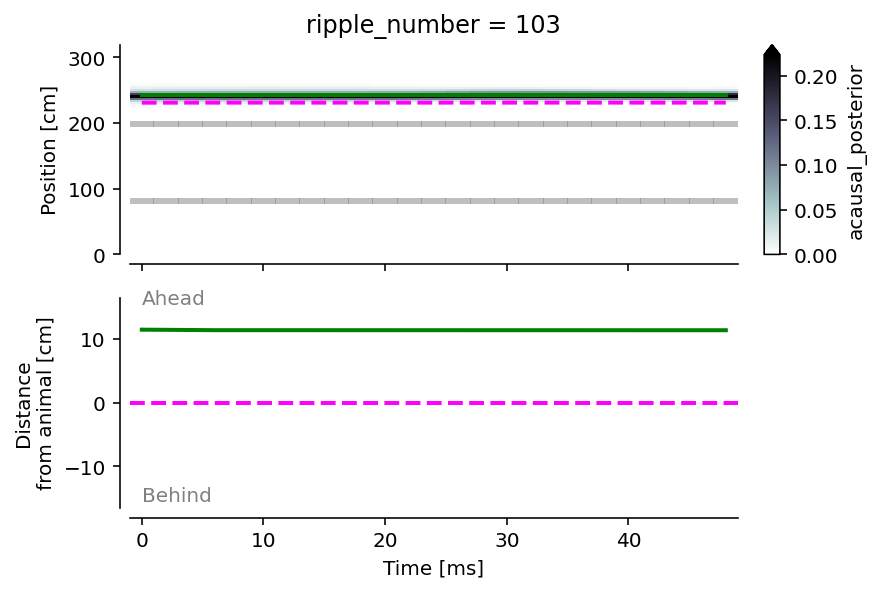

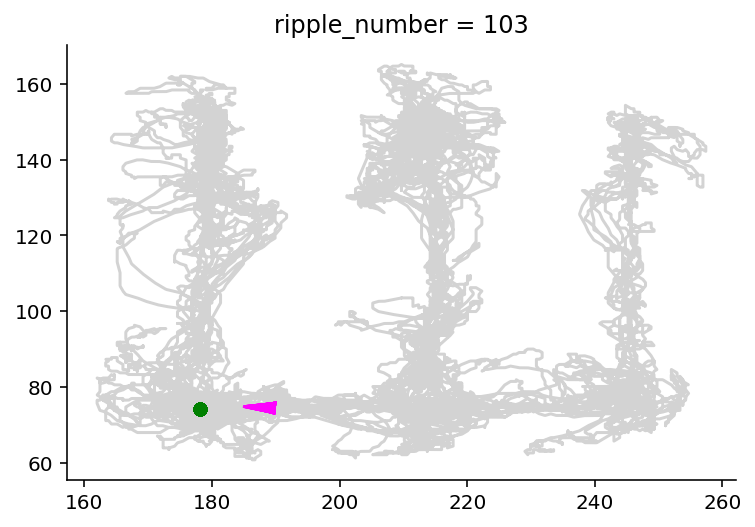

In [18]:
ripple_number = 103
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

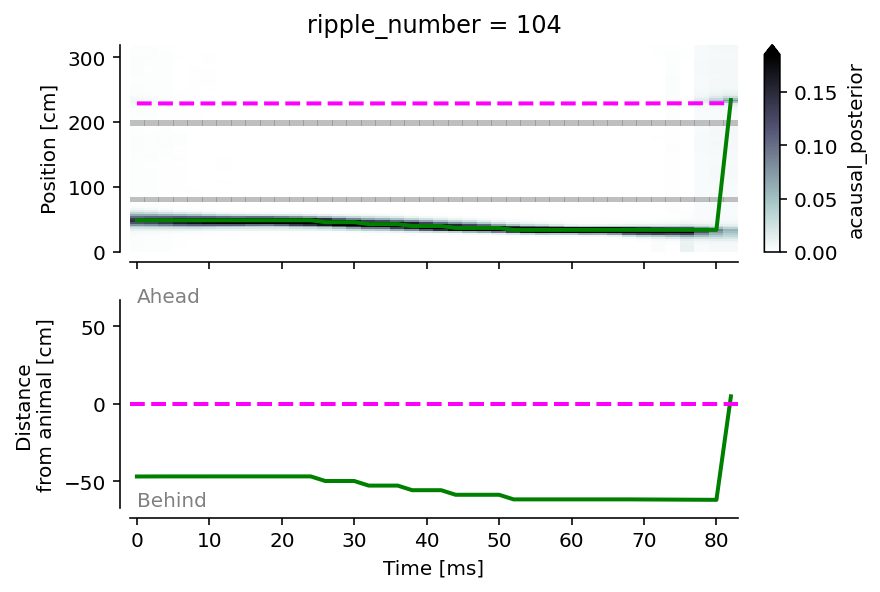

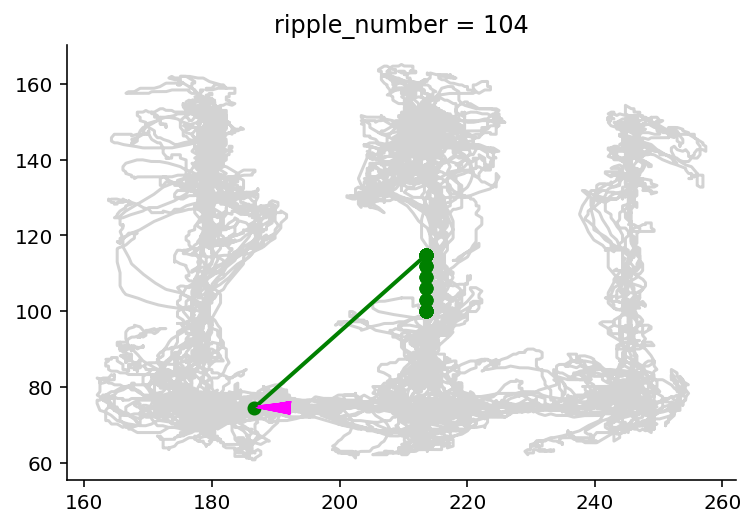

In [19]:
ripple_number = 104
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

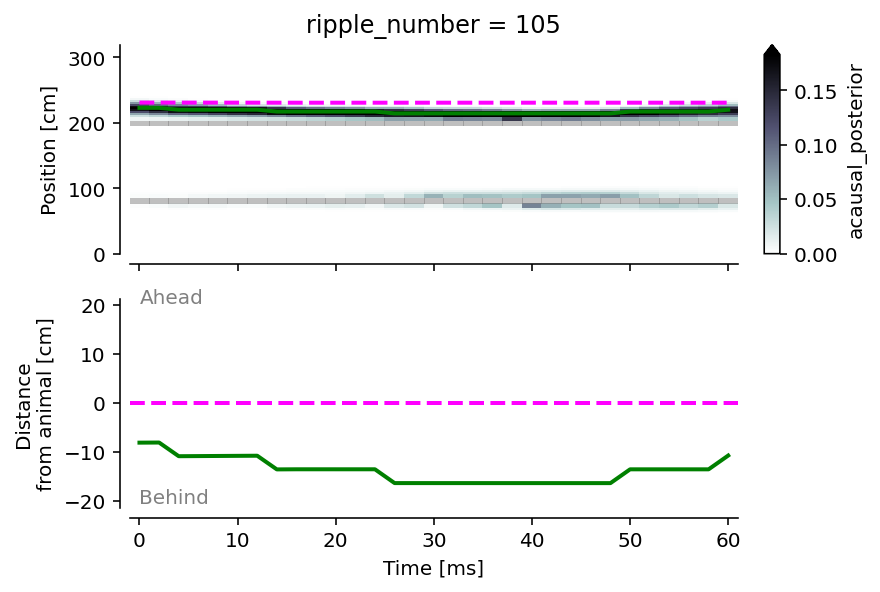

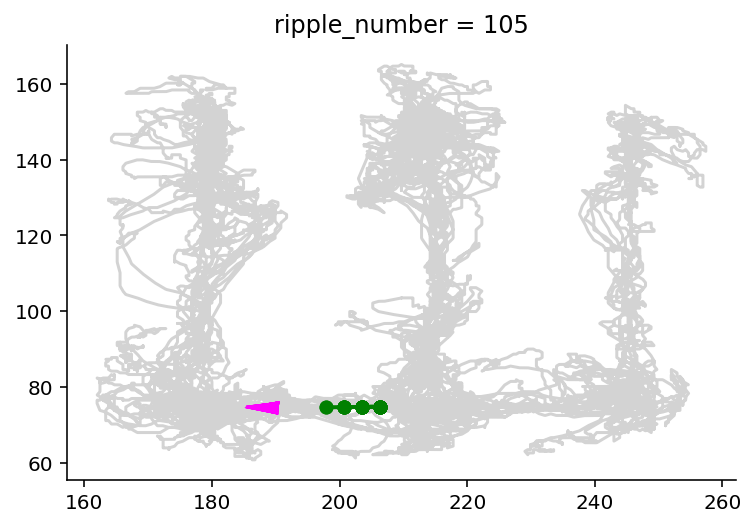

In [20]:
ripple_number = 105
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

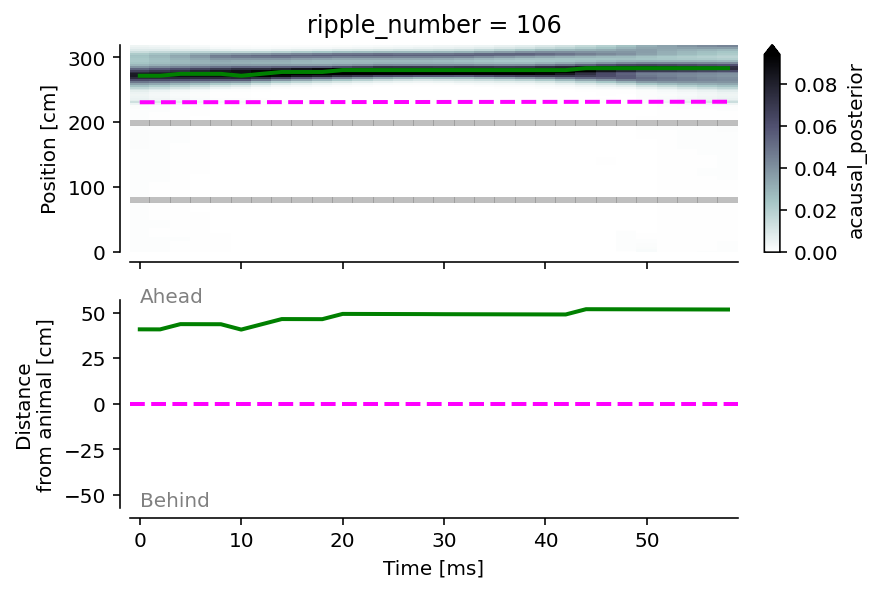

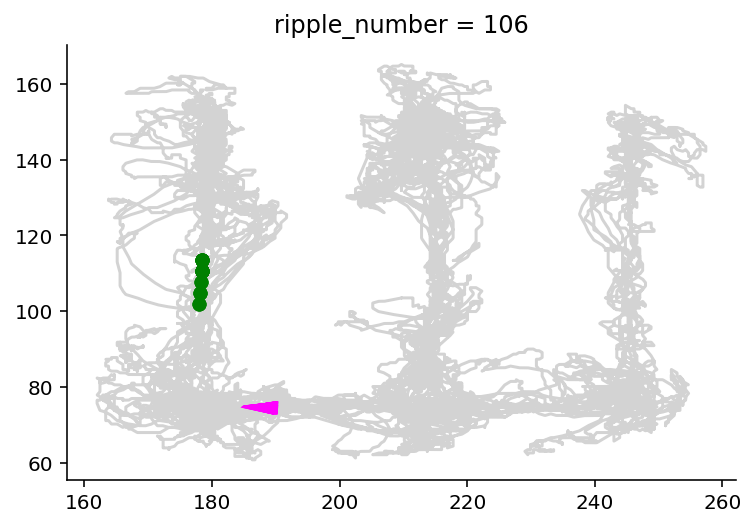

In [22]:
ripple_number = 106
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

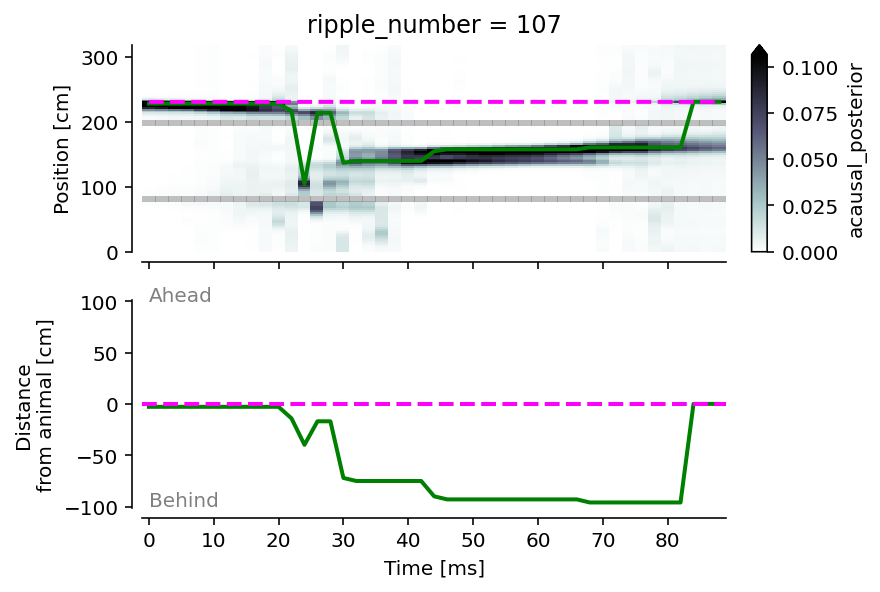

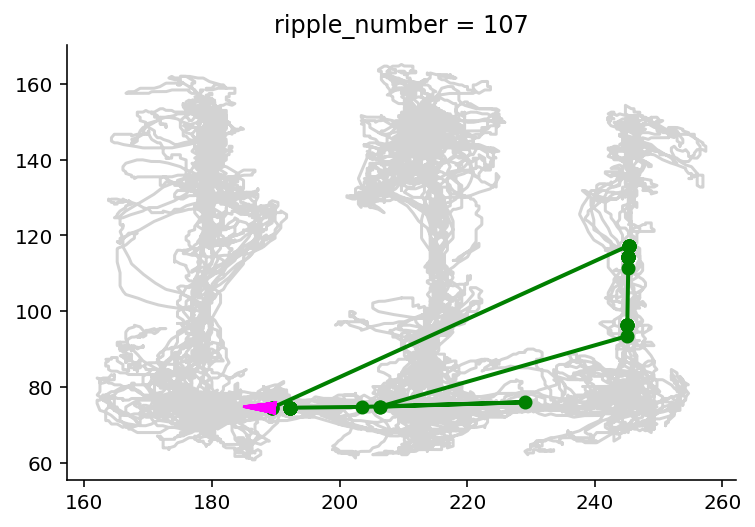

In [21]:
ripple_number = 107
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

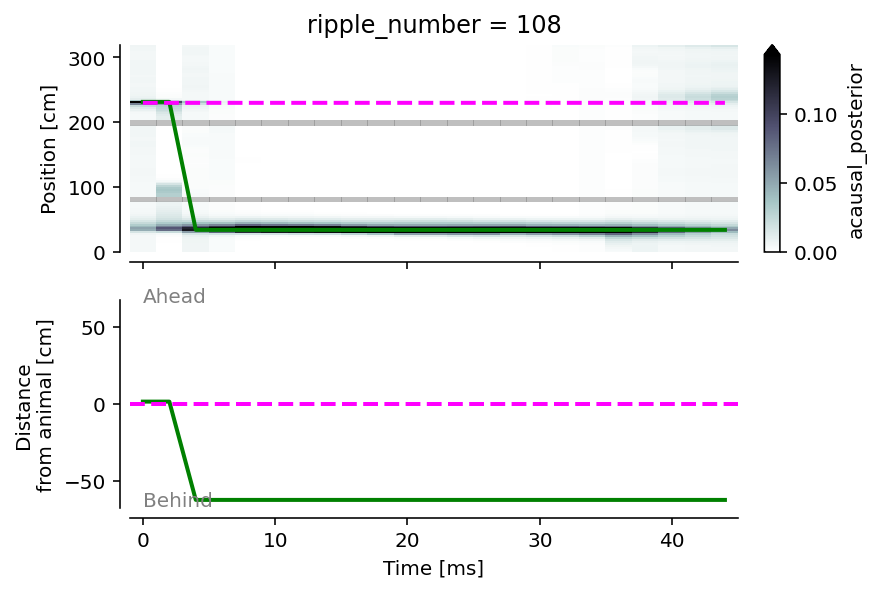

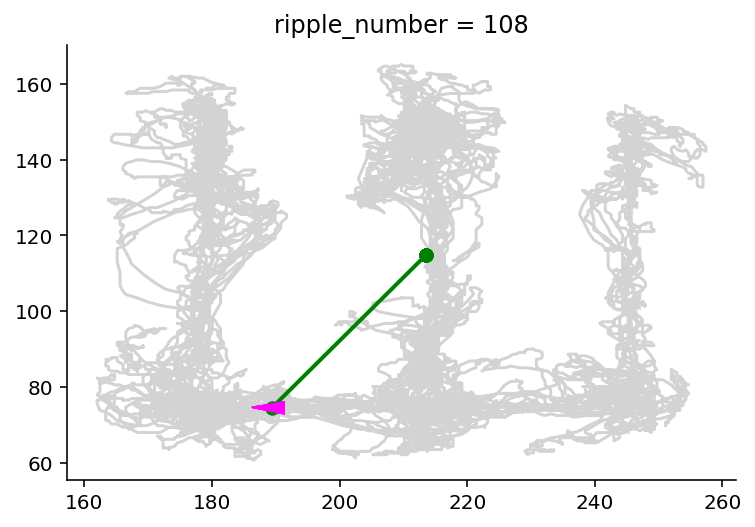

In [23]:
ripple_number = 108
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

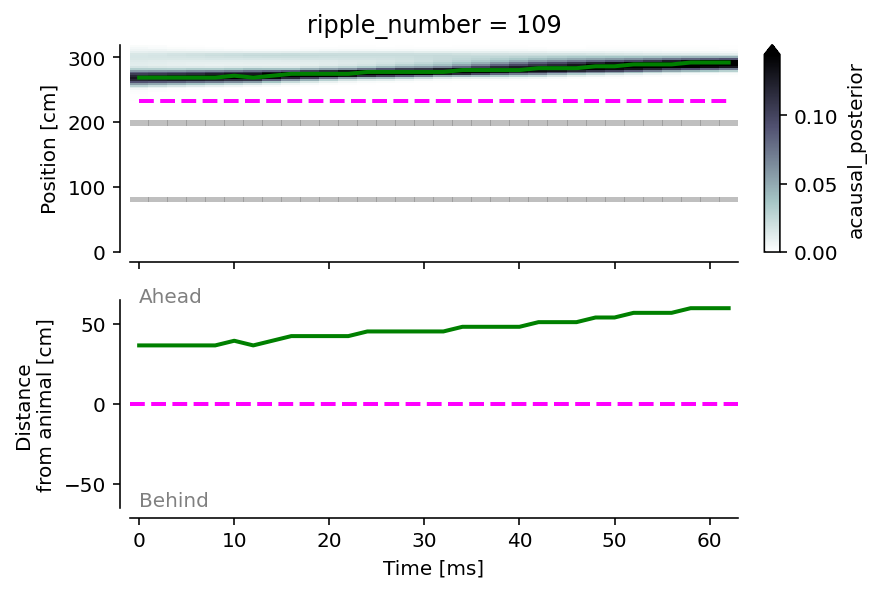

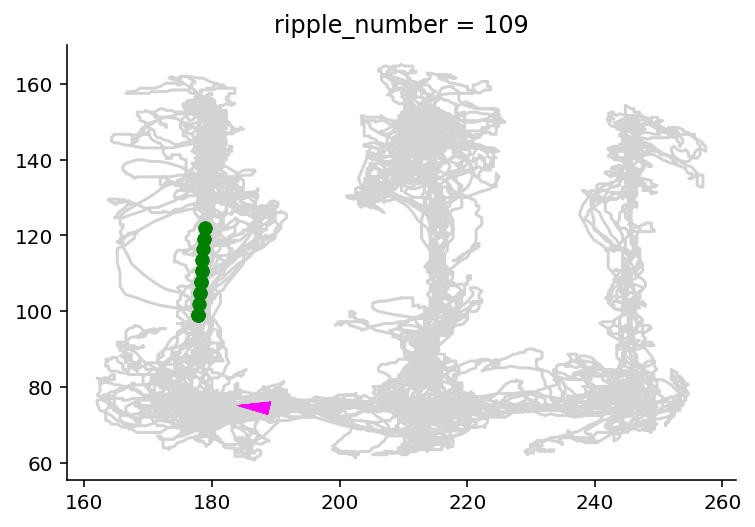

In [24]:
ripple_number = 109
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

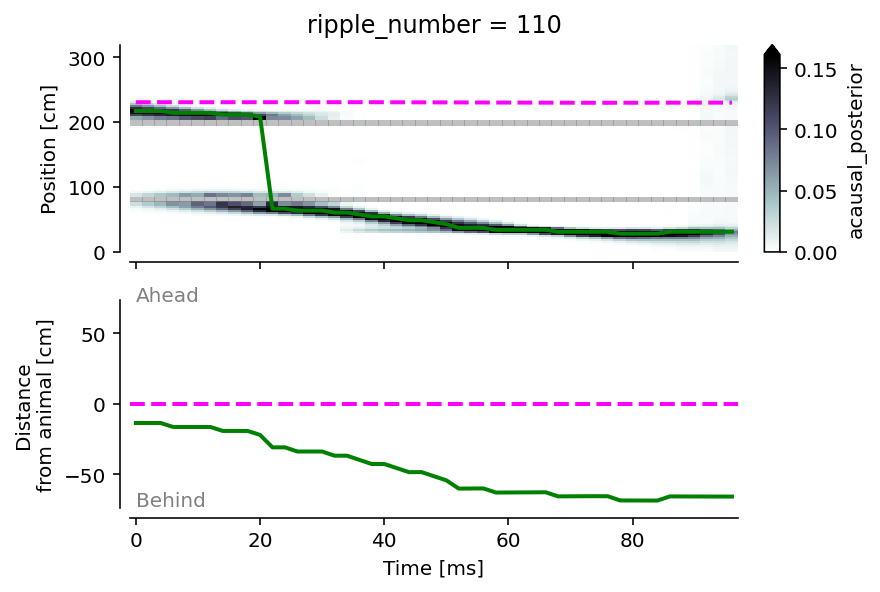

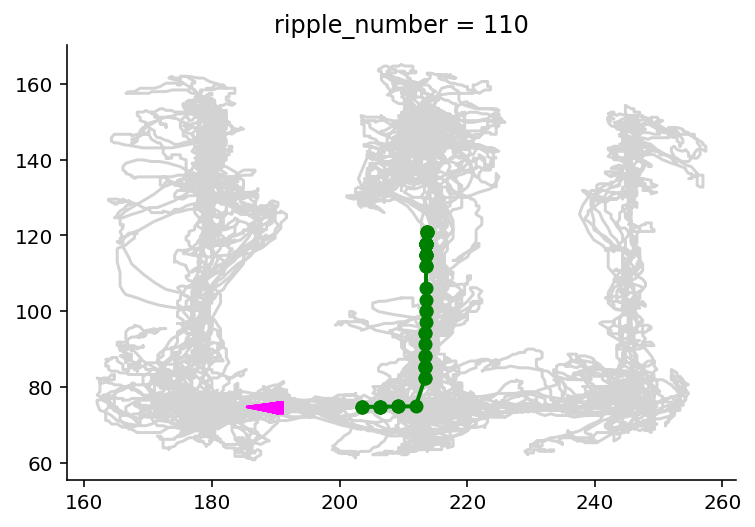

In [25]:
ripple_number = 110
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

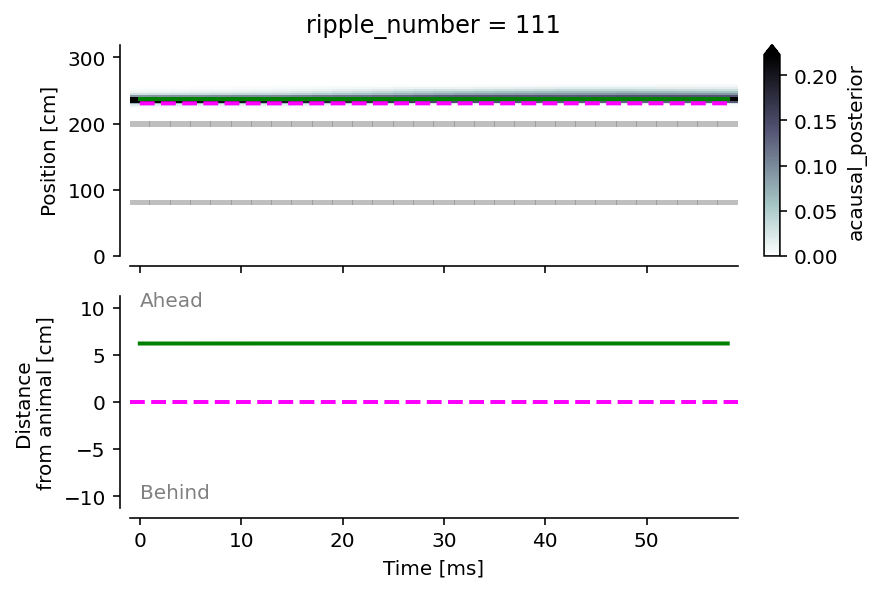

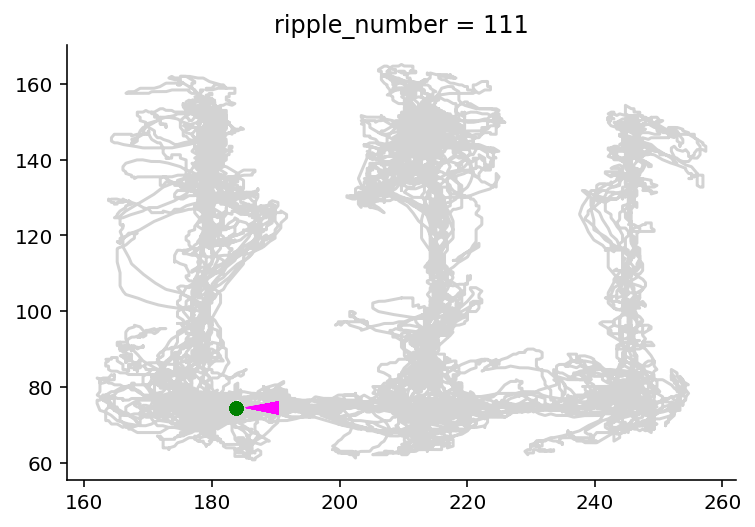

In [26]:
ripple_number = 111
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

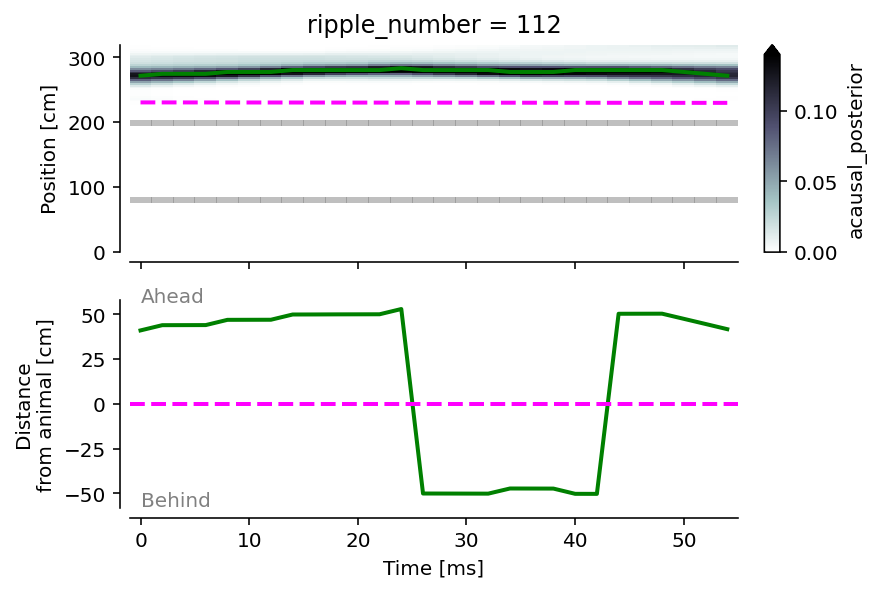

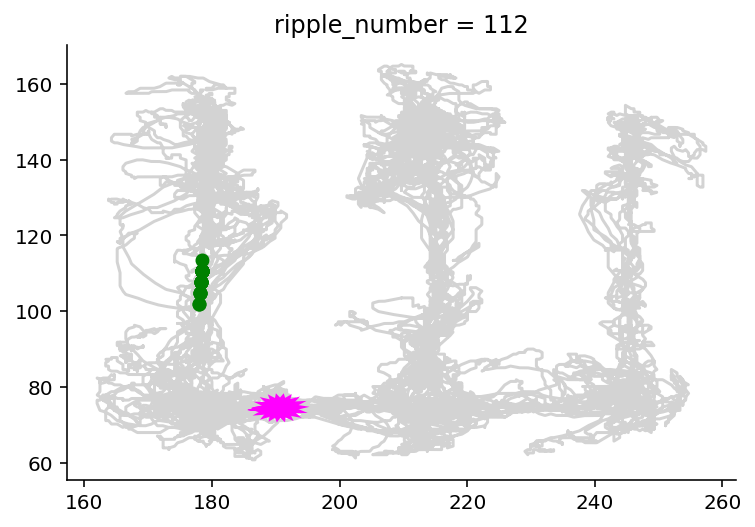

In [27]:
ripple_number = 112
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

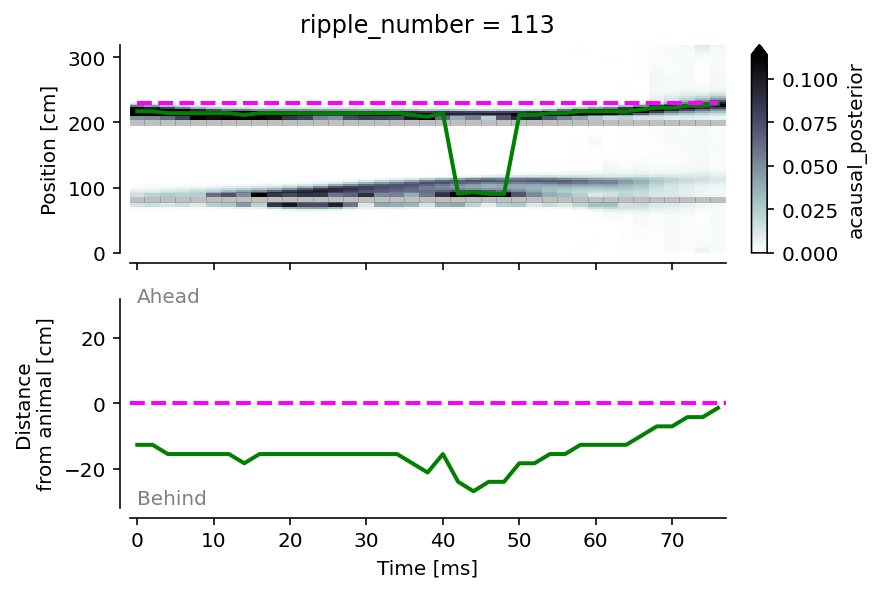

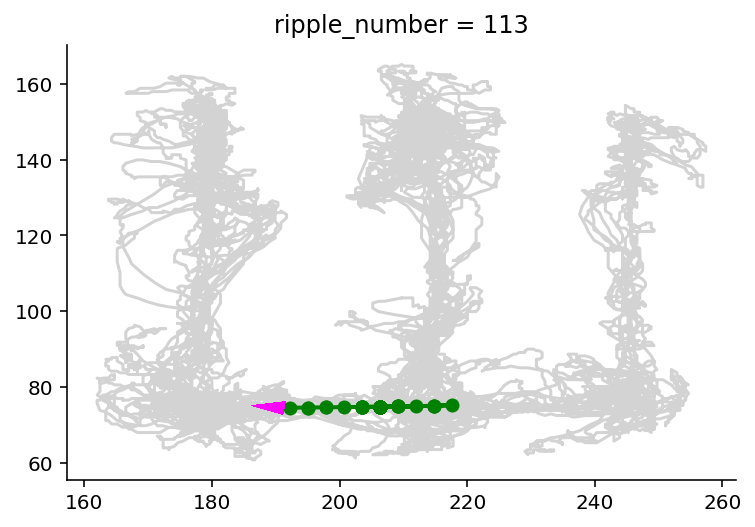

In [28]:
ripple_number = 113
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

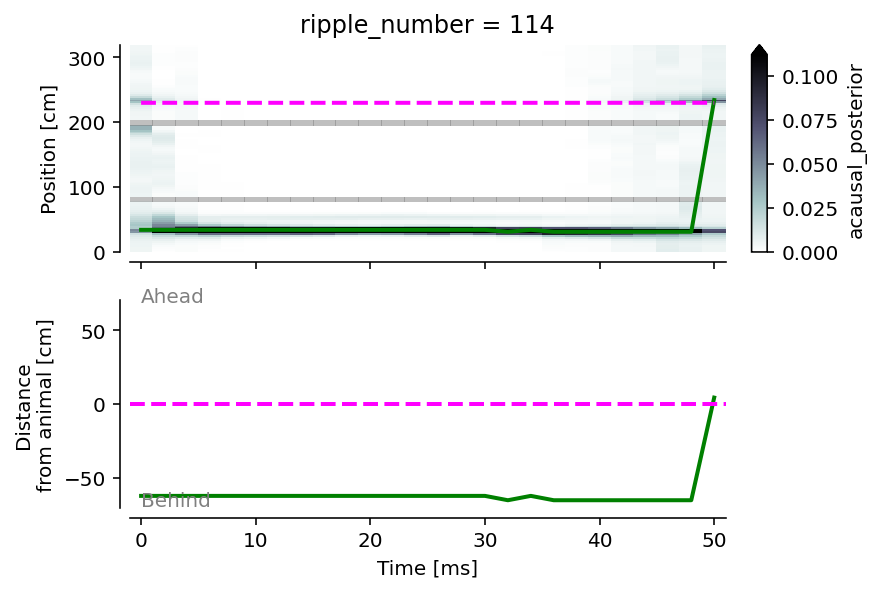

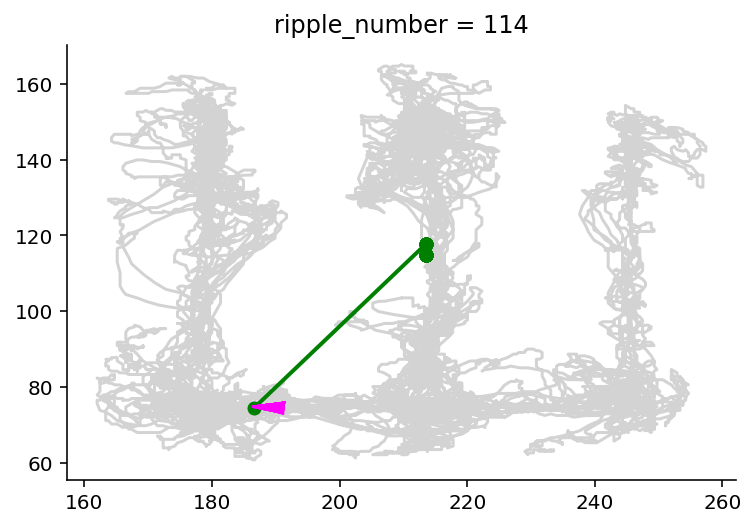

In [29]:
ripple_number = 114
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

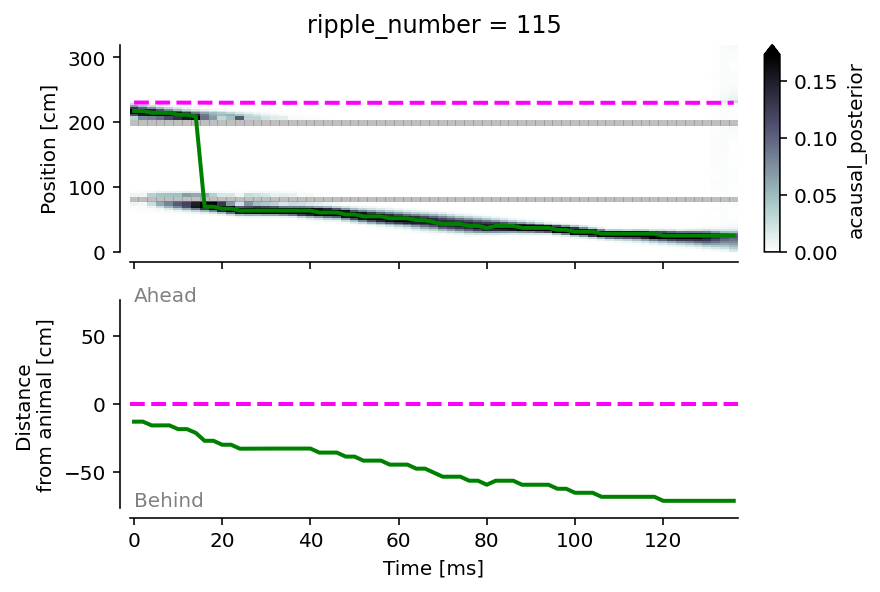

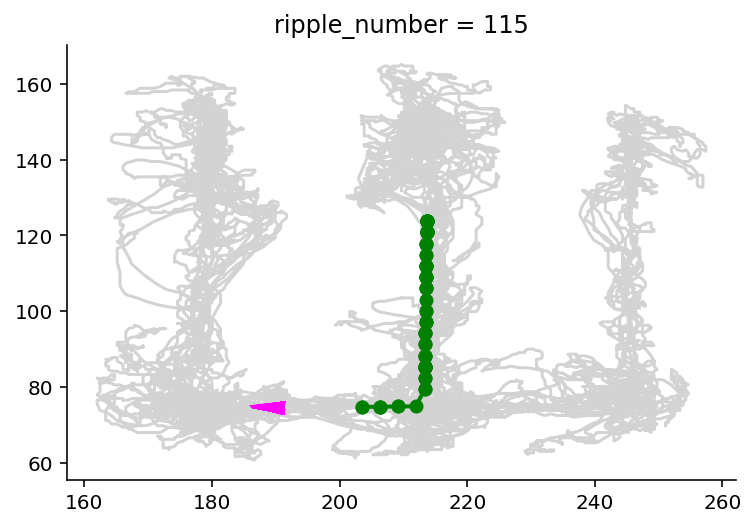

In [30]:
ripple_number = 115
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)

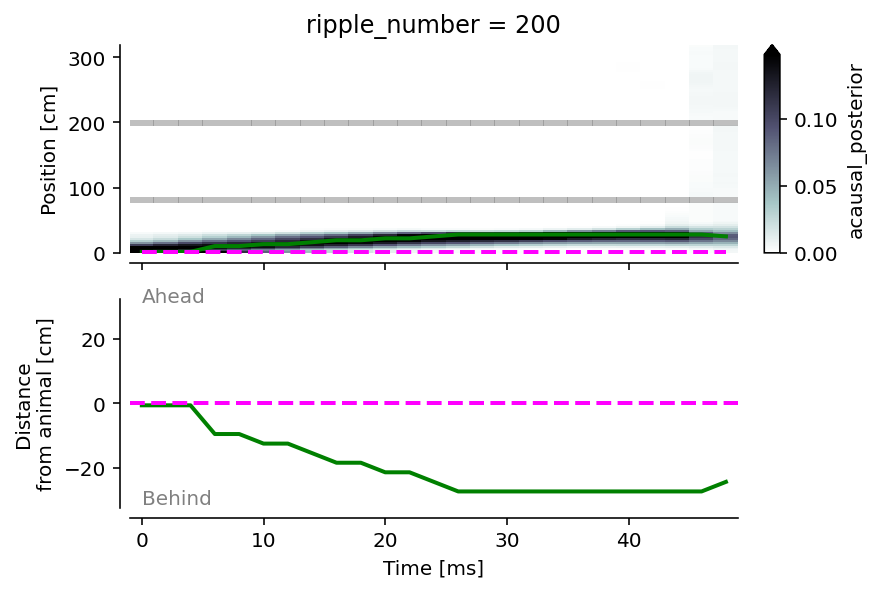

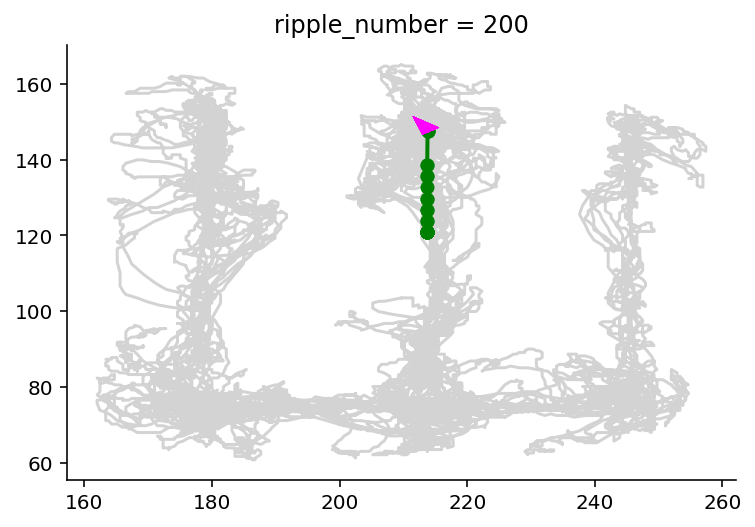

In [31]:
ripple_number = 200
plot_ahead_behind(ripple_number, results, track_graph, classifier, ripple_position_info)